# Lesson 4 - FastAI

## Learning the basics of classification

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)  #path for data

In [4]:
#hide
Path.BASE_PATH = path

In [5]:
path.ls()


(#3) [Path('train'),Path('labels.csv'),Path('valid')]

In [6]:
(path/'train').ls()

(#2) [Path('train/3'),Path('train/7')]

In [7]:
threes = (path/'train'/'3').ls().sorted() #getting 3's data from path
sevens = (path/'train'/'7').ls().sorted() #getting 7's data from path
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [8]:
im3_path = threes[1]
im3 = Image.open(im3_path) #shows image
im3

In [9]:
array(im3)[4:10,4:10] #numpy to convert image into quantitative rep

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [10]:
tensor(im3)[4:10,4:10] #same thing as numpy array but work better on GPU's (preferred)

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [11]:
im3.shape

(28, 28)

In [12]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys') #Using panda's framework

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


## First Try: Pixel Similarity

In [13]:
#create list of all images in the form of tensors
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors), len(seven_tensors)

(6131, 6265)

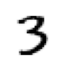

In [33]:
show_image(three_tensors[1]);

In [ ]:
#Right now our tensors are lists. We must fix this.
type(three_tensors)

list

In [14]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

In [16]:
len(stacked_threes.shape) #Returns rank. Rank means it has n dementions

3

In [17]:
stacked_threes.ndim

3

In [15]:
mean3 = stacked_threes.mean() #notice taking mean gives a number
mean3

tensor(0.1415)

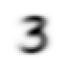

In [16]:
mean3 = stacked_threes.mean(0) #the 0 represents the axis we are doing the mean across (In this case across the first axis 6131)
show_image(mean3);

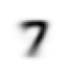

In [17]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

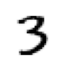

In [18]:
a_3 = stacked_threes[1]
show_image(a_3);

In [ ]:
#Find difference between images using one of the following:
dist_3_abs = (a_3 - mean3).abs().mean() #L1 norm
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt() #RMSE or L2 norm
dist_3_abs,dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [ ]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In [ ]:
#Another approach
F.l1_loss(a_3.float(),mean7),   F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

### NumPy Arrays and PyTorch Tensors
#### ***Just some comparison between tensors and numpy arrays***

In [ ]:
data = [[1,2,3],[4,5,6]]
arr = array (data)
tns = tensor(data)

In [ ]:
arr  # numpy

array([[1, 2, 3],
       [4, 5, 6]])

In [ ]:
tns  # pytorch

tensor([[1, 2, 3],
        [4, 5, 6]])

In [ ]:
tns[1]

tensor([4, 5, 6])

In [ ]:
tns[:,1]

tensor([2, 5])

In [ ]:
tns[1,1:3]

tensor([5, 6])

In [ ]:
tns+1

tensor([[2, 3, 4],
        [5, 6, 7]])

In [ ]:
tns.type()

'torch.LongTensor'

In [ ]:
tns*1.5

tensor([[1.5000, 3.0000, 4.5000],
        [6.0000, 7.5000, 9.0000]])

## Computing Metrics Using Broadcasting

In [19]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255

valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255


valid_3_tens.shape,   valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [20]:
def mnist_distance(a,b): 
  return (a-b).abs().mean((-1,-2)) #mean across 2nd and last axis (28,28)
mnist_distance(a_3, mean3)

tensor(0.1114)

In [21]:
valid_3_dist = mnist_distance(valid_3_tens, mean3) #broadcast method across entire validation set
valid_3_dist, valid_3_dist.shape

(tensor([0.1787, 0.1422, 0.1412,  ..., 0.1358, 0.1301, 0.1110]),
 torch.Size([1010]))

In [ ]:
tensor([1,2,3]) + tensor([1]) #broadcasting example

tensor([2, 3, 4])

In [ ]:
(valid_3_tens-mean3).shape

torch.Size([1010, 28, 28])

In [19]:
def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7)

In [24]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [ ]:
a_7 = stacked_sevens[1]
a_7

<AxesSubplot:>

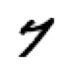

In [26]:
show_image(a_7)

In [ ]:
is_3(a_7), is_3(a_7).float() #tensor val is 0

(tensor(False), tensor(0.))

In [ ]:
is_3(valid_3_tens)

tensor([True, True, True,  ..., True, True, True])

In [20]:
accuracy_3s =      is_3(valid_3_tens).float() .mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

## **I will test this simple model below with my input image I drew in paint**

In [65]:
uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

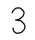

In [66]:
img = PILImage.create(uploader.data[0])
img.to_thumb(40)

In [67]:
img = img.resize((28,28)) #Resizing img

In [68]:
t_3 = tensor(img) #converting to tensor

In [69]:
#t_3.view(-1,28*28)

In [70]:
t_3.shape

torch.Size([28, 28, 3])

In [71]:
t_3 = t_3[:,:,0] #dropping channels

<AxesSubplot:>

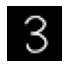

In [72]:
show_image(t_3)

In [73]:
t_3.shape

torch.Size([28, 28])

In [74]:
is_3(t_3) #Nice, it got it right!

tensor(True)

## Stochastic Gradient Descent (SGD)

In [38]:
def f(x): return x**2

/opt/conda/envs/fastai/lib/python3.8/site-packages/fastbook/__init__.py:73: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729096996/work/aten/src/ATen/native/RangeFactories.cpp:23.)
  x = torch.linspace(min,max)


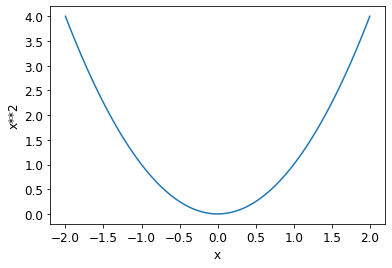

In [39]:
plot_function(f, 'x', 'x**2')

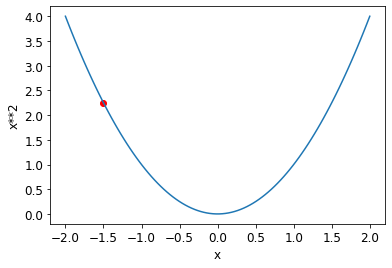

In [40]:
plot_function(f, 'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red');

### Calculating Gradients

In [41]:
xt = tensor(3.).requires_grad_() #The method requires_grade_ tells pyTorch that it must keep track of all comput. so we can calc grad on them later

In [42]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [43]:
yt.backward() #backprop

In [44]:
xt.grad #Slope at pos 3

tensor(6.)

In [45]:
#Another example, but this time with an array of values
xt = tensor([3.,4.,10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

In [46]:
def f(x): return (x**2).sum()

yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [47]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

### Stepping With a Learning Rate

### An End-to-End SGD Example

In [48]:
time = torch.arange(0,20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

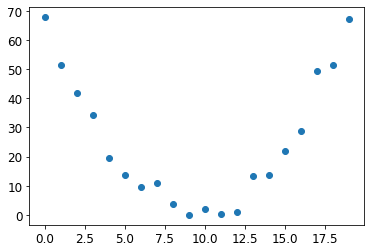

In [49]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time,speed);

In [50]:
#our assumed function for the above graph
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

In [51]:
#calculates loss
def mse(preds, targets): 
    return ((preds-targets)**2).mean().sqrt() #mean squared error

#### Step 1: Initialize the parameters

In [52]:
params = torch.randn(3).requires_grad_() #Getting random weights
params

tensor([0.2815, 0.0562, 0.5227], requires_grad=True)

In [53]:
#hide
orig_params = params.clone()

#### Step 2: Calculate the predictions

In [54]:
preds = f(time, params)

In [55]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)

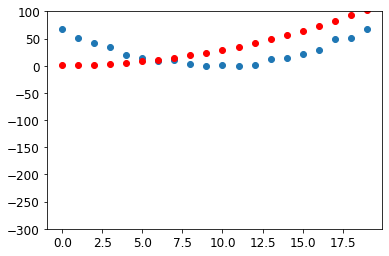

In [56]:
show_preds(preds) #Red is our predictions, Blue is the labels

#### Step 3: Calculate the loss

In [58]:
loss = mse(preds, speed) #Current loss
loss

tensor(35.6327, grad_fn=<SqrtBackward>)

#### Step 4: Calculate the gradients

In [59]:
loss.backward()
params.grad

tensor([121.4830,   7.8875,   0.3013])

In [60]:
params.grad * 1e-5      #1e-5 is the learning rate

tensor([1.2148e-03, 7.8875e-05, 3.0131e-06])

#### Step 5: Step the weights. 

In [61]:
print(params.data)  #.data is used so gradient is NOT calc
print(params)

tensor([0.2815, 0.0562, 0.5227])
tensor([0.2815, 0.0562, 0.5227], requires_grad=True)


In [62]:
lr = 1e-4
params.data -= lr * params.grad.data
params.grad = None

In [63]:
preds = f(time,params)
mse(preds, speed) #loss improved

tensor(34.1798, grad_fn=<SqrtBackward>)

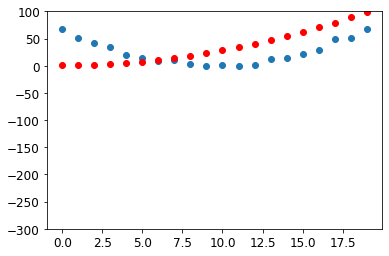

In [64]:
show_preds(preds)

## Putting all of the above into a simple function

In [65]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

#### Step 6: Repeat the process 

In [66]:
for i in range(10): apply_step(params) #running it 10 times (Notice loss improving)

34.17982482910156
32.844730377197266
31.63145637512207
30.54193687438965
29.575712203979492
28.729764938354492
27.998600006103516
27.374542236328125
26.84825325012207
26.409330368041992


In [67]:
#hide
params = orig_params.detach().requires_grad_()

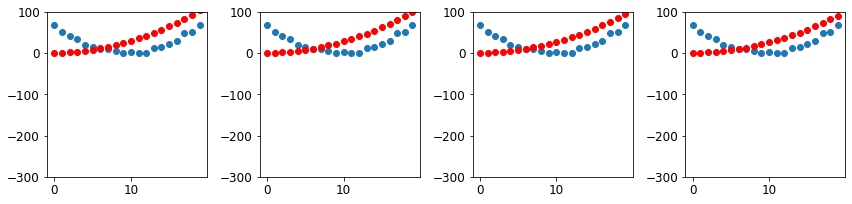

In [68]:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

#### Step 7: stop

## The MNIST Loss Function

In [69]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28) #.view reshapes the image where each row has 1 image 
                                                                    # with all its content in a single row (each image is 28x28)

In [70]:
#Creating labels: 1 represents a three and 0 represents seven
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [71]:
dset = list(zip(train_x,train_y)) #zip() creates a concatination of x,y
x,y = dset[0] 
x.shape,y

(torch.Size([784]), tensor([1]))

In [72]:
#create validation set using same approach as above
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

In [73]:
#initializing weights
def init_params(size, var=1.0): return (torch.randn(size)*var).requires_grad_()

In [74]:
weights = init_params((28*28,1)) #weights needed for every pixel, hence 28*28

In [77]:
bias = init_params(1) #Need bias because w*p = 0 when p=0 (p = pixel)

In [78]:
#Single pred for 1 image
(train_x[0]*weights.T).sum() + bias #Must transpose so multi can happen

tensor([21.8052], grad_fn=<AddBackward0>)

In [79]:
#More efficient using matrix multi
def linear1(xb): 
    return xb@weights + bias #@ repersents matrix multi

preds = linear1(train_x)
preds #preds of all images 

tensor([[21.8052],
        [11.4321],
        [19.5403],
        ...,
        [ 6.7101],
        [ 7.7558],
        [ 0.4296]], grad_fn=<AddBackward0>)

### Lets assume everything greater 0 is correctly labeled

In [80]:
corrects = (preds>0.0).float() == train_y
corrects

tensor([[ True],
        [ True],
        [ True],
        ...,
        [False],
        [False],
        [False]])

In [81]:
corrects.float().mean().item() #Displays accuracy

0.49951598048210144

## Now lets see how the accuracy changes for a small change in the weights

In [82]:
weights[0] *= 1.0001

#### Notice that the accuracy did not change  - This is why we make use of a loss function

In [83]:
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.49951598048210144

### Example showcasing the effects of loss

In [84]:
#Example - Assume we have these targets and these predictions
trgts  = tensor([1,0,1])
prds   = tensor([0.9, 0.4, 0.2])

In [85]:
def mnist_loss(predictions, targets):
                                   #Where not 1    #Where 1
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [42]:
torch.where(trgts==1, 1-prds, prds)

tensor([0.1000, 0.4000, 0.8000])

In [43]:
mnist_loss(prds,trgts)

tensor(0.4333)

In [45]:
mnist_loss(tensor([0.9, 0.4, 0.8]),trgts) #What happens when we change the last pred (loss gets better)

tensor(0.2333)

### Sigmoid

In [86]:
def sigmoid(x): return 1/(1+torch.exp(-x))

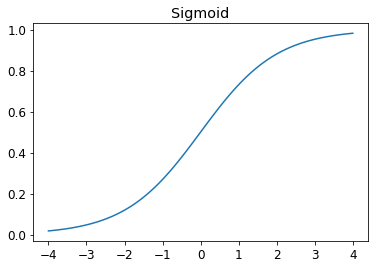

In [87]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

In [88]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid() #squishing predictions between 0-1
    return torch.where(targets==1, 1-predictions, predictions).mean()

### SGD and Mini-Batches

In [89]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True) #creates minibatches
list(dl)

[tensor([ 3, 12,  8, 10,  2]),
 tensor([ 9,  4,  7, 14,  5]),
 tensor([ 1, 13,  0,  6, 11])]

In [90]:
ds = L(enumerate(string.ascii_lowercase)) 
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

In [91]:
dl = DataLoader(ds, batch_size=6, shuffle=True)  #Works with tuples as well
list(dl)

[(tensor([17, 18, 10, 22,  8, 14]), ('r', 's', 'k', 'w', 'i', 'o')),
 (tensor([20, 15,  9, 13, 21, 12]), ('u', 'p', 'j', 'n', 'v', 'm')),
 (tensor([ 7, 25,  6,  5, 11, 23]), ('h', 'z', 'g', 'f', 'l', 'x')),
 (tensor([ 1,  3,  0, 24, 19, 16]), ('b', 'd', 'a', 'y', 't', 'q')),
 (tensor([2, 4]), ('c', 'e'))]

## Putting It All Together

In [92]:
#get initial weights and bias
weights = init_params((28*28,1))
bias = init_params(1)

In [95]:
dl = DataLoader(dset, batch_size=256) #create minibatches

#We can grab the first batch and take a look at it
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [96]:
valid_dl = DataLoader(valid_dset, batch_size=256) #Create minibatch for validation set

### Creating and testing with our own batch first

In [97]:
#Create batch
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [ ]:
linear1??

In [99]:
#Get pred
preds = linear1(batch)
preds

tensor([[10.1946],
        [ 3.4763],
        [12.7263],
        [ 7.4847]], grad_fn=<AddBackward0>)

In [100]:
#Calc loss
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.0076, grad_fn=<MeanBackward0>)

In [125]:
mnist_loss??

In [101]:
#Calc grad
loss.backward()
weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([784, 1]), tensor(-0.0011), tensor([-0.0074]))

### Put the above into a single func

In [102]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [262]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-7.1430e-05), tensor([-0.0005]))

In [263]:
#If we call it again, the values change: This should NOT happen
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0001), tensor([-0.0008]))

In [264]:
#Fix the issue above by setting to 0
weights.grad.zero_()
bias.grad.zero_();

### How to do an epoch

In [105]:
def train_epoch(model, lr, params):
    for xb,yb in dl: #get x and y batch
        calc_grad(xb, yb, model) #Calc grad
        
        for p in params: 
            p.data -= p.grad*lr #Update/take a step
            p.grad.zero_() #Set grad to zero

In [106]:
(preds>0.0).float() == train_y[:4]

tensor([[True],
        [True],
        [True],
        [True]])

In [107]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5).float() == yb  #.5 because sigmoid(0) = .5
    return correct.float().mean()

In [108]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(1.)

In [109]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [110]:
validate_epoch(linear1)

0.4607

In [111]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.637

In [112]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1))

0.791
0.8925
0.9315
0.9476
0.9515
0.9579
0.9637
0.9652
0.9667
0.9672
0.9677
0.9701
0.9706
0.9711
0.9725
0.9735
0.9735
0.974
0.974
0.9745


### Creating an Optimizer - Basically optimizing the above stuff we did

In [115]:
                      #Weights #Bias
linear_model = nn.Linear(28*28,1) #Does exactly what out funtion linear1 does and initialzes our parameters for us

In [116]:
 #Viewing the parameters
w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [118]:
class BasicOptim:
    def __init__(self,params,lr): 
        self.params = list(params)
        self.lr = lr
 
    def step(self, *args, **kwargs):
        for p in self.params: 
            p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: 
            p.grad = None

In [119]:
opt = BasicOptim(linear_model.parameters(), lr)

In [120]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [121]:
validate_epoch(linear_model)

0.3794

In [122]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [123]:
train_model(linear_model, 20)

0.4932 0.7476 0.8511 0.9155 0.9346 0.9482 0.9555 0.9629 0.9658 0.9673 0.9707 0.9722 0.9736 0.9751 0.9761 0.9766 0.9775 0.9775 0.9785 0.9785 

## Can further optimize by using fastai  

In [124]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr) 
train_model(linear_model, 20)

0.4932 0.7393 0.8613 0.9175 0.9365 0.9497 0.957 0.9634 0.9663 0.9673 0.9702 0.9727 0.9736 0.9751 0.9761 0.9766 0.9775 0.978 0.978 0.979 

### Finally the most simplest way

In [126]:
dls = DataLoaders(dl, valid_dl) #NOT dataLoader, this class stores away the train and valid data into a single obj

In [127]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [128]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.636365,0.503465,0.495584,00:00
1,0.521433,0.170448,0.864082,00:00
2,0.191138,0.189521,0.824828,00:00
3,0.083866,0.109406,0.910697,00:00
4,0.044337,0.079229,0.932777,00:00
5,0.028900,0.063259,0.947007,00:00
6,0.022547,0.053348,0.954367,00:00
7,0.019723,0.046764,0.961727,00:00
8,0.018294,0.042152,0.965653,00:00
9,0.017439,0.038766,0.967615,00:00


## Adding a Nonlinearity

In [129]:
def simple_net(xb): 
    res = xb@w1 + b1 #Linear func
    res = res.max(tensor(0.0)) #Activation func: ReLU
    res = res@w2 + b2 #Linear func
    return res

In [130]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

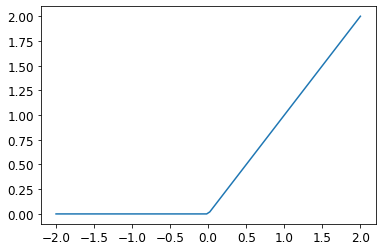

In [131]:
plot_function(F.relu)

In [134]:
#Can use sequential method to create nonlinearity
simple_net = nn.Sequential(
    nn.Linear(28*28,30), #30 sets of weights
    nn.ReLU(),
    nn.Linear(30,1) #convert back into 1 set of weights
)

In [135]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [136]:
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.324376,0.404988,0.505888,00:00
1,0.150483,0.233413,0.803238,00:00
2,0.083043,0.117188,0.912169,00:00
3,0.054295,0.078788,0.940628,00:00
4,0.040957,0.061365,0.956330,00:00
5,0.034142,0.051610,0.962709,00:00
6,0.030232,0.045451,0.965653,00:00
7,0.027697,0.041252,0.967125,00:00
8,0.025878,0.038205,0.968106,00:00
9,0.024475,0.035891,0.970069,00:00


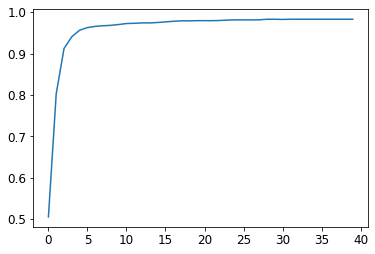

In [137]:
plt.plot(L(learn.recorder.values).itemgot(2));

In [138]:
learn.recorder.values[-1][2]

0.982826292514801

In [139]:
m = learn.model
m

Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
)

In [140]:
w, b = m[0].parameters()

In [141]:
w.shape

torch.Size([30, 784])

In [ ]:
#w[0].view(28,28)

<AxesSubplot:>

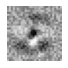

In [147]:
show_image(w[2].view(28,28))

### Going Deeper - Using FastAI's model resnet18

In [148]:
dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1) 

#Thats insane

epoch,train_loss,valid_loss,accuracy,time
0,0.132423,0.036220,0.995093,00:17


## Questionnaire

1. **How is a grayscale image represented on a computer? How about a color image?**  
Image on the computer are represented by a number value, where 0=white, 255=black, and the grayscale inbetween.  
A grayscale image is rank 2 (No color channels)  
A color image is rank 3 (Has the 3 color channels, RGB)
1. **How are the files and folders in the `MNIST_SAMPLE` dataset structured? Why?**  
Files are split into train, valid, labels. This makes it easier as the training and validation set have already been presplit for for.
1. **Explain how the "pixel similarity" approach to classifying digits works.**  
This is similer to the Nearest neighbors approach, where one compare each test image with all training images. Only here, the image being compared to is an average of all the training images. Then using a distance metric we can find the abs difference between the images to identify it. 
1. **What is a list comprehension? Create one now that selects odd numbers from a list and doubles them.** 
A python condensing technique used with for-loop.  

```python
l = [i for i in range(20)]
oddList = [i**2 for i in l if i%2 != 0]
```
1. **What is a "rank-3 tensor"?**  
A 3 dimensional tensor (Also known as a volumn).
1. **What is the difference between tensor rank and shape? How do you get the rank from the shape?**  
Rank refers to the number of dimensions in a tensor  
Shape is the size of each dimension of a tensor  
  
  Taking the len(shape) = rank
1. **What are RMSE and L1 norm?**  
Loss functions
1. **How can you apply a calculation on thousands of numbers at once, many thousands of times faster than a Python loop?**  
Broadcasting
1. **Create a 3×3 tensor or array containing the numbers from 1 to 9. Double it. Select the bottom-right four numbers.**  
```python
t = tensor(list(range(1,10))).view(3,3)
t[1:,0:2]
```
1. **What is broadcasting?**  
A technique of applying an operation onto all values within an object, often, regardless of tensor (Exceptions do apply).  
1. **Are metrics generally calculated using the training set, or the validation set? Why?**  
Validation set as it contains unseen data. 
1. **What is SGD?**  
Optimization algorithm. This is what causes the loss to decrease as it steps/updates the parameters. 
1. **Why does SGD use mini-batches?**  
Minibatches are faster and more efficient on GPU. Also, they gradient is calculated more appropriately as doing it across the entire batch could cause unstable and imprecise gradients. 
1. **What are the seven steps in SGD for machine learning?**  
Initialize parameters  
Compute perdiction  
Get loss  
Get gradients  
Update wieghts  
Repeat  
Stop
1. **How do we initialize the weights in a model?**  
Randomly
1. **What is "loss"?**  
A metric used by the computer to determine its performance
1. **Why can't we always use a high learning rate?**  
Stepping to far can cause the model to increase loss or bounce and diverge
1. **What is a "gradient"?**  
Slope. This tell us how much we have to change each weight to make our model better.
1. **Do you need to know how to calculate gradients yourself?**  
No
1. **Why can't we use accuracy as a loss function?**  
A loss function needs to change as the weights are being adjusted. Accuracy only changes if the predictions of the model changes. 
1. **Draw the sigmoid function. What is special about its shape?** 
![](https://forums.fast.ai/uploads/default/original/3X/1/1/11fa5da9a15e9b4db282ff9bc1f8237073173e7d.png)  
Squishes all values between 0-1
1. **What is the difference between a loss function and a metric?**  
The loss function is understood by the computer, while a metric is understood by us humans.
1. **What is the function to calculate new weights using a learning rate?**  
The optimizer step function (Ex: SGD).
1. **What does the `DataLoader` class do?**  
Creates minibatches
1. **Write pseudocode showing the basic steps taken in each epoch for SGD.**  
```python
for x,y in data:
    pred = model(x)
    loss = loss_func(pred, y)
    loss.backward()
    
    for p in self.params:
        p -= parameters.grad * lr
        p.grad = None
```
1. **Create a function that, if passed two arguments `[1,2,3,4]` and `'abcd'`, returns `[(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')]`. What is special about that output data structure?**  
```python
def func(l1,l2):
    return list(zip(l1,l2))
```
1. **What does `view` do in PyTorch?**  
Reshapes tensor
1. **What are the "bias" parameters in a neural network? Why do we need them?**  
So that the gradient isnt set to 0 during the first iteration.
1. **What does the `@` operator do in Python?**  
Matrix multi
1. **What does the `backward` method do?**  
Calculated gradients
1. **Why do we have to zero the gradients?**  
PyTorch remembers the previously stored gradients
1. **What information do we have to pass to `Learner`?**  
dataset (DataLoaders), model (Ex:  nn.Linear), opt func (Ex: SGD), loss func (Ex: mnist_loss), metric(Optional)
1. **Show Python or pseudocode for the basic steps of a training loop.**  
```python
    def train_epoch(model,lr,params):
        for x,y in dl:
            calc_grad(x,y,model)

        for p in self.params:
            p -= parameters.grad * lr
            p.grad = None

    for i in range(epochs):
        train_epoch(model, lr, params)
```
    
1. **What is "ReLU"? Draw a plot of it for values from `-2` to `+2`.**  
Activation function
1. **What is an "activation function"?**  
The purpose of an activation function is to add non-linearity to the model. 
1. **What's the difference between `F.relu` and `nn.ReLU`?**  
F.relu is a Python function
nn.ReLU is a PyTorch module (So part of a class)
1. **The universal approximation theorem shows that any function can be approximated as closely as needed using just one nonlinearity. So why do we normally use more?**  
There are performance benefits to using more than one nonlinearity

### Further Research

1. **Create your own implementation of `Learner` from scratch, based on the training loop shown in this chapter.**  
1. **Complete all the steps in this chapter using the full MNIST datasets (that is, for all digits, not just 3s and 7s). This is a significant project and will take you quite a bit of time to complete! You'll need to do some of your own research to figure out how to overcome some obstacles you'll meet on the way.**  
Completed. See https://usama280.github.io/PasteBlogs/